# Task Distribution
| Member | ID | Tasks |
|---|---|---|
|Bhavika| - | - | 
|Alora| - | - |
|Andrea| - | - |

# Import Libraries

In [295]:
%pip install tweepy


Note: you may need to restart the kernel to use updated packages.


In [296]:
import tweepy
import sys
import csv
import pandas as pd
import re
import numpy as np


# Scraping Tweets

In [297]:
# Keys for authentication
consumer_key = "ONLQ0vLSAXM2tZDnckominEcK"
consumer_secret = "MpP7XurdGn1wpufX3rrfQgrs4AROnaw9ZiiZzKN6exr3zEDlN6"
access_token = "1274112117738737664-J2DjjoqqzN11CNp8bpnYzVp1dUYKM4"
access_token_secret = "3coYFJVCqHnOmD2m9Qt6zs7j1I24lhlPTU71eUOq4Zqg9"
bearer_token = "AAAAAAAAAAAAAAAAAAAAALJslQEAAAAA7EWdkTwrVDM44LIuewNascHjvoY%3DeXmhQyuXgo8zXJiSTMfqtmPA393HHO2W7nSrk0bK6b67SuJeb0"


In [298]:
# Authenticate
auth = tweepy.OAuth1UserHandler(
    consumer_key, consumer_secret, access_token, access_token_secret)

api = tweepy.API(auth)


In [299]:
def scrape_tweets(query: str, amount: int) -> list:
    """Scrapes a specified number of tweets based on given query and location.

    Method from https://www.sahilfruitwala.com/guide-to-extract-tweets-using-tweepy#how-to-retrieve-specific-number-of-tweets-using-tweepy 

    Args:
        query (str): The query
    Returns:
        list (str): List of contents of tweets.
    """
    extracted_tweets = []
    for tweet in tweepy.Cursor(api.search_tweets, query, count=100, tweet_mode="extended", result_type="recent").items(amount):
        extracted_tweets.append(tweet.full_text)
    return extracted_tweets


In [300]:
def write_to_csv(tweets: list, csv_name: str) -> None:
    """Appends the list of tweets to csv.

    Largely copied from https://gist.github.com/anku255/0cebd75cce675f2b56de1ef48ec06575.

    """
    print("Writing {0} tweets to {1}".format(len(tweets), csv_name))
    tweets_for_csv = [[tweet.encode("utf-8")] for tweet in tweets]
    with open(csv_name, "a+") as file:
        writer = csv.writer(file, delimiter=",")
        writer.writerows(tweets_for_csv)


The queries for scraping tweets.

In [301]:

queries = [
    ["(metaverse OR meta verse OR #metaverse OR #meta #verse) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(innovation OR #innovation OR innovate OR innovative OR #innovate OR #innovative) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(sustainability OR #sustainability OR sustainable) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(technology footprint OR technology OR #technologyfootprint) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(artificial intelligence OR ai OR #ai OR #artificialintelligence) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(ethics OR #ethics OR ethical OR #ethical) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(inflation OR #inflation) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(cop 28 OR cop28 OR #cop28 OR #cop #28) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(museum of the future OR @museumofthefuture OR #museumofthefuture OR #museum #of #the #future) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(bit coin OR bitcoin OR #bitcoin OR #crypto OR crpyto OR cryptocurrency) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(cyber attack OR #cyberattack OR #cyber OR #cyberattacks OR #cyber #attack) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(robot OR robots OR #robots OR #robot) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(drone OR drones OR #drone OR #drones) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(hacker OR hacking OR #hacker OR #hacking OR #hack) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(chatgpt OR #chatgpt OR #chat #gpt OR chat gpt) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(cybersecurity OR #cybersecurityOR #cybersec OR cybersec OR cyber security OR #cyber #security) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(sustainabletech OR sustainable ai OR sustainable technology OR #sustainabletech OR #sustainableai OR #sustainabletechnology) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(computing OR quantum computing OR #quantum #computing OR #computing) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(automation OR #automation) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(distributed cloud OR #distributedcloud OR #distributed #cloud) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(big data OR #big #data OR bigdata OR #bigdata) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(ar OR #ar OR #augmentedreality OR #augmented #reality) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(data mining OR #data #mining OR #datamining) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(software OR #software) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(tech OR technology OR #tech OR #technology) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(digital OR digital transformation OR #digital #transformation OR #digitaltransformation) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(blockchain OR #blockchain) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(coders_hq OR coders hq OR #coders OR #coders #hq OR @coders_hq) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(nft OR non-fungible token OR non fungible token OR nfts OR #nfts OR #nonfungibletoken OR #nft) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(binance OR @binance OR #binance) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(uae hackathon OR hackathon OR #hackathon) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(internet of things OR IoT OR #iot OR #internet #of #things OR #internetofthings) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(software engineering OR #softwareengineering) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(#coding OR coding) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(@uaeai OR #uaeai Or #uae #ai) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(technology OR tech OT #tech Or #technology) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(nft OR #nft OR #nfts OR nfts) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(UAE codes OR #UAE_codes OR #UAEcodes) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(Microsoft Hololens OR Hololens OR #Hololens) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(GITEX or #gitex) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(information OR #information) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(internet OR #internet) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(computer OR science OR computer science OR #computerscience OR #computer OR #science) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(technological OR #technological) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(engineering OR #engineering) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(computing OR #computing) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(systems OR #systems) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(electronics OR #electronics) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(application OR #application OR app OR #app) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(robotics OR #robotics) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(high tech OR high technology OR #hightech OR #hightechnology OR #high #technology OR #high #tech) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(nanotech OR nano tech OR nanotechnology OR nano technology OR #nanotech OR #nano #tech OR #nano #technology OR #nanotechnology) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(biotech OR bio tech OR biotechnology OR bio technology OR #biotech OR #bio #tech OR #bio #technology OR #biotechnology) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(code OR #code) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(automation OR #automation OR automate OR #automate) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(virtual OR #virtual OR online OR #online) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(technological advancements OR #technological #advancements OR #advancements OR #techadvancements) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(bionics OR #bionics) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(cyberscience OR #cyberscience) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(google OR #google OR @google) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(oracle OR #oracle OR @oracle) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(ibm OR #ibm OR @ibm) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(bionics OR #bionics) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(sap OR #sap) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(global knowledge OR #globalknowledge OR #global #knowledge) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(amazon OR #amazon OR @amazon) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(hewlett-packard OR Hewlett Packard OR HP OR #hewlett-packard OR #Hewlett #Packard OR #HP) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(cisco OR #cisco OR @cisco) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(dell OR #dell OR @dell) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(cisco OR #cisco OR @cisco) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(@WorldGovSummit OR #WGS OR #WGS2023 OR World Goverment Summit) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(masdar OR #masdar OR @masdar) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(renewable energy OR clean energy OR #renewableenergy OR #cleanenergy) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(machine learning OR #machinelearning OR ML OR #ML) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(recommender systems OR #RS OR #recommender #systems OR recommender engine) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(deep learning OR #deeplearning) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(research OR #research) AND (place_country:AE OR uae) lang:en -filter:retweets"],
]


Commented out below to prevent re-running code.

In [302]:
# """Scraping tweets and writing them to dataset.csv"""
# csv_name="dataset.csv"
# total = 0
# for query in queries:
#     tweets = scrape_tweets(query=query, amount=500)
#     total += len(tweets)
#     print("Found {0} tweets related to the query {1}".format(len(tweets), query))
#     write_to_csv(tweets=tweets,csv_name=csv_name)
# print("Done. {0} rows.".format(total))


# Data Cleaning

This section cleans the scraped tweets dataset of duplicate tweets, URLs, @'s and #s.

Note: 
- Do not modify original csv `dataset.csv`. The dataset with no duplicates is stored in `updated_dataset.csv`

In [303]:
# Dropping duplicates
dataset = pd.read_csv("dataset.csv", header=None)
dataset.rename(columns={0: 'Text'}, inplace=True)


In [304]:
dataset


,Text
0,b'Joined UAE Minister &amp; President-Designat...
1,b'Foreign Secretary @AmbVMKwatra participated ...
2,"b'As the UAE marks National Environment Day, w..."
3,b'RT @KhalifaAlgaz: Did you know that the UAE ...
4,b'RT @tawhidChtioui: \xf0\x9f\x9b\xb0\xef\xb8\...
...,...
21974,b'Send our special gifts to your loved ones!\x...
21975,b'Trainer code: 2735 9457 4031\nfrom \xf0\x9f\...
21976,"b""We are looking for ICY SNOW , SANDSTORM .\nI..."
21977,b'Make #MONEY from #home through PC #APP \nMak...


In [305]:
updated_dataset = dataset.drop_duplicates().copy()
updated_dataset


,Text
0,b'Joined UAE Minister &amp; President-Designat...
1,b'Foreign Secretary @AmbVMKwatra participated ...
2,"b'As the UAE marks National Environment Day, w..."
3,b'RT @KhalifaAlgaz: Did you know that the UAE ...
4,b'RT @tawhidChtioui: \xf0\x9f\x9b\xb0\xef\xb8\...
...,...
21888,b'@m_ut67 @modgovae @Forsan_UAE Dear sir pleas...
21889,b'@UAE_BARQ Dear sir please my help you sir my...
21890,b'@UAE_BARQ Dear sir please my help you sir my...
21915,"b""#PhonePe launched a service on Tuesday that ..."


### Removing URLs, @'s and hashtags

In [306]:
tweets = updated_dataset['Text'].copy()
updated_dataset['Cleaned Text'] = tweets.str.replace(
    r'@[^\s]+|#[^\s]+|https?:\/\/\S+|www\.\S+', '', regex=True)
updated_dataset['Cleaned Text'].head()


0    b'Joined UAE Minister &amp; President-Designat...
1    b'Foreign Secretary  participated in a meeting...
2    b'As the UAE marks National Environment Day, w...
3    b'RT  Did you know that the UAE is developing ...
4    b'RT  \xf0\x9f\x9b\xb0\xef\xb8\x8f UAE lunar r...
Name: Cleaned Text, dtype: object

### Removing Duplicates again

In [307]:
updated_dataset = updated_dataset.drop('Text', axis=1)
updated_dataset = updated_dataset.drop_duplicates()
updated_dataset.shape


(5398, 1)

In [308]:
updated_dataset.to_csv('updated-dataset.csv')


In [309]:
updated_dataset = pd.read_csv('updated-dataset.csv', index_col=0)
updated_dataset


,Cleaned Text
0,b'Joined UAE Minister &amp; President-Designat...
1,b'Foreign Secretary participated in a meeting...
2,"b'As the UAE marks National Environment Day, w..."
3,b'RT Did you know that the UAE is developing ...
4,b'RT \xf0\x9f\x9b\xb0\xef\xb8\x8f UAE lunar r...
...,...
21888,b' Dear sir please my help you sir my two ki...
21889,b' Dear sir please my help you sir my two kidn...
21890,b' Dear sir please my help you sir my two kidn...
21915,"b"" launched a service on Tuesday that will all..."


# Data Labelling


### TextBlob

For data labelling, we decided to use first use TextBlob. TextBlob calculates the subjectivity and polarity of a text to classify the text as 'Positive', 'Negative' or 'Neutral'

In [310]:
# %pip install TextBlob


In [311]:
from textblob import TextBlob


In [312]:
# Function to get subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity


# Function to get the polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity


# Create two new columns ‘Subjectivity’ & ‘Polarity’
updated_dataset['TextBlob Subjectivity'] = updated_dataset['Cleaned Text'].apply(
    getSubjectivity)
updated_dataset['TextBlob Polarity'] = updated_dataset['Cleaned Text'].apply(
    getPolarity)


def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'


updated_dataset['TextBlob Sentiment'] = updated_dataset['TextBlob Polarity'].apply(
    getAnalysis)


In [313]:
updated_dataset['TextBlob Sentiment'].value_counts()


Positive    2643
Neutral     2276
Negative     479
Name: TextBlob Sentiment, dtype: int64

It can be observed that TextBlob classified the majority of tweets to be Positive. To compare, we also decided to use Vader as well to observe if there was a major difference in classification.

### Vader

In [314]:
# %pip install vaderSentiment


In [315]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sentiment = SentimentIntensityAnalyzer()


def getSentiment(text):
    return sentiment.polarity_scores(text)


updated_dataset['Vader Analysis'] = updated_dataset['Cleaned Text'].apply(
    getSentiment)


def sentimentAnalysis(sentiment_dict):
    if sentiment_dict['compound'] >= 0.05:
        return 'Positive'
    elif sentiment_dict['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'


updated_dataset['Vader Sentiment'] = updated_dataset['Vader Analysis'].apply(
    sentimentAnalysis)


In [316]:
updated_dataset[['Vader Analysis', 'Vader Sentiment']]


,Vader Analysis,Vader Sentiment
0,"{'neg': 0.0, 'neu': 0.638, 'pos': 0.362, 'comp...",Positive
1,"{'neg': 0.0, 'neu': 0.816, 'pos': 0.184, 'comp...",Positive
2,"{'neg': 0.0, 'neu': 0.766, 'pos': 0.234, 'comp...",Positive
3,"{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'comp...",Positive
4,"{'neg': 0.0, 'neu': 0.819, 'pos': 0.181, 'comp...",Positive
...,...,...
21888,"{'neg': 0.073, 'neu': 0.726, 'pos': 0.202, 'co...",Positive
21889,"{'neg': 0.073, 'neu': 0.726, 'pos': 0.202, 'co...",Positive
21890,"{'neg': 0.074, 'neu': 0.719, 'pos': 0.206, 'co...",Positive
21915,"{'neg': 0.043, 'neu': 0.774, 'pos': 0.183, 'co...",Positive


In [317]:
updated_dataset['Vader Sentiment'].value_counts()


Positive    3335
Neutral     1691
Negative     372
Name: Vader Sentiment, dtype: int64

## Analysis between Vader and TextBlob


| Data Labelling Method      | Positive Label | Negative Label | Neutral Label |
| ----------- | ----------- | ----------- | ----------- |
| TextBlob      | 2643   (49%)   |479  (8.9%)| 2276 (42.1%)|
| Vader   | 3335  (61.8%)      | 372 (6.9%) | 1691 (31.3%)|

From the summary table, we can observe that the negatively labelled tweets stay within a 2% difference of each other, regardless of the data labelling method. However, the positive and neutral label differ by 10%.

In [318]:
# Creating a csv of tweets with conflicting sentiments
unclearTweets = updated_dataset.loc[(
    updated_dataset['Vader Sentiment'] != updated_dataset['TextBlob Sentiment'])]
unclearTweets.to_csv('ConflictingLabels.csv')


In [319]:
unclearTweets


,Cleaned Text,TextBlob Subjectivity,TextBlob Polarity,TextBlob Sentiment,Vader Analysis,Vader Sentiment
1,b'Foreign Secretary participated in a meeting...,0.562500,-0.062500,Negative,"{'neg': 0.0, 'neu': 0.816, 'pos': 0.184, 'comp...",Positive
3,b'RT Did you know that the UAE is developing ...,0.000000,0.000000,Neutral,"{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'comp...",Positive
4,b'RT \xf0\x9f\x9b\xb0\xef\xb8\x8f UAE lunar r...,1.000000,-0.600000,Negative,"{'neg': 0.0, 'neu': 0.819, 'pos': 0.181, 'comp...",Positive
10,b'RT UK BUSINESS SECRETARY PRAISES UK-UAE GRA...,0.000000,0.000000,Neutral,"{'neg': 0.0, 'neu': 0.484, 'pos': 0.516, 'comp...",Positive
14,"b'RT As host of COP28, UAE is committed to le...",0.125000,0.000000,Neutral,"{'neg': 0.0, 'neu': 0.817, 'pos': 0.183, 'comp...",Positive
...,...,...,...,...,...,...
21888,b' Dear sir please my help you sir my two ki...,0.100000,0.000000,Neutral,"{'neg': 0.073, 'neu': 0.726, 'pos': 0.202, 'co...",Positive
21889,b' Dear sir please my help you sir my two kidn...,0.100000,0.000000,Neutral,"{'neg': 0.073, 'neu': 0.726, 'pos': 0.202, 'co...",Positive
21890,b' Dear sir please my help you sir my two kidn...,0.100000,0.000000,Neutral,"{'neg': 0.074, 'neu': 0.719, 'pos': 0.206, 'co...",Positive
21915,"b"" launched a service on Tuesday that will all...",0.062500,-0.062500,Negative,"{'neg': 0.043, 'neu': 0.774, 'pos': 0.183, 'co...",Positive


After manually reviewing the differences in labels, it seems that the TextBlob sentiment labelling is more accurate.

# Data Preprocessing

**approach → first data cleaning + tokenization + lemmatization**

## Additional Data Cleaning

### Removing Non-English Characters

In [320]:
def nonenglish(tweet):
    # tweets in different language changed to hex code \xhh
    tweet = re.sub(r'\\x[a-zA-Z0-9]+', '', tweet)
    tweet = re.sub(r'\\n', '', tweet)  # removing new line character as well
    return tweet


updated_dataset['Cleaned Text'] = updated_dataset['Cleaned Text'].apply(
    lambda tweet: nonenglish(tweet).lower())
updated_dataset['Cleaned Text'].head()


0    b'joined uae minister &amp; president-designat...
1    b'foreign secretary  participated in a meeting...
2    b'as the uae marks national environment day, w...
3    b'rt  did you know that the uae is developing ...
4    b'rt   uae lunar rover will test 1st artificia...
Name: Cleaned Text, dtype: object

### Removing Stopwords

In [321]:
from sklearn.feature_extraction import text

# contains 318 stopwords, including but not limited to articles and prepositions
stopwords = text.ENGLISH_STOP_WORDS
updated_dataset['Cleaned Text'] = updated_dataset['Cleaned Text'].apply(
    lambda tweet: ' '.join([text for text in tweet.split(' ') if text not in stopwords]))
updated_dataset['Cleaned Text'].head()


0    b'joined uae minister &amp; president-designat...
1    b'foreign secretary  participated meeting foca...
2    b'as uae marks national environment day, remai...
3    b'rt  did know uae developing arabic chatgpt u...
4    b'rt   uae lunar rover test 1st artificial int...
Name: Cleaned Text, dtype: object

### Removing Symbols and Punctuations

In [322]:
import string

punctuations = string.punctuation
print(punctuations)

updated_dataset['Cleaned Text'] = updated_dataset['Cleaned Text'].apply(
    lambda tweet: tweet.translate({ord(punc): None for punc in punctuations}))
updated_dataset['Cleaned Text'].head()


!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


0    bjoined uae minister amp presidentdesignate  d...
1    bforeign secretary  participated meeting focal...
2    bas uae marks national environment day remain ...
3    brt  did know uae developing arabic chatgpt us...
4    brt   uae lunar rover test 1st artificial inte...
Name: Cleaned Text, dtype: object

### Removing Numbers

In [323]:
updated_dataset['Cleaned Text'] = updated_dataset['Cleaned Text'].apply(
    lambda tweet: re.sub('[0-9]+', '', tweet))
updated_dataset['Cleaned Text'].head()


0    bjoined uae minister amp presidentdesignate  d...
1    bforeign secretary  participated meeting focal...
2    bas uae marks national environment day remain ...
3    brt  did know uae developing arabic chatgpt us...
4    brt   uae lunar rover test st artificial intel...
Name: Cleaned Text, dtype: object

### Removing 'b' and 'rt'

In [324]:
def removeb(tweet):
    if tweet[:3] == 'brt':
        return tweet[3:]
    else:
        return tweet[1:]
updated_dataset['Cleaned Text'] = updated_dataset['Cleaned Text'].apply(
    lambda tweet: removeb(tweet))
updated_dataset['Cleaned Text'].head()


0    joined uae minister amp presidentdesignate  dr...
1    foreign secretary  participated meeting focal ...
2    as uae marks national environment day remain c...
3      did know uae developing arabic chatgpt using...
4       uae lunar rover test st artificial intellig...
Name: Cleaned Text, dtype: object

### Tokenization

In [325]:
# as data has been completely cleaned, we can simply tokenize by converting strings to lists
updated_dataset['Tokenized Text'] = updated_dataset['Cleaned Text'].apply(
    lambda tweet: tweet.split())
updated_dataset['Tokenized Text'].head()


0    [joined, uae, minister, amp, presidentdesignat...
1    [foreign, secretary, participated, meeting, fo...
2    [as, uae, marks, national, environment, day, r...
3    [did, know, uae, developing, arabic, chatgpt, ...
4    [uae, lunar, rover, test, st, artificial, inte...
Name: Tokenized Text, dtype: object

### Lemmatization

In [326]:
import nltk
lemmatizing = nltk.stem.WordNetLemmatizer()

updated_dataset['Lemmatized Text'] = updated_dataset['Tokenized Text'].apply(
    lambda tweet: [lemmatizing.lemmatize(text).lower() for text in tweet])
updated_dataset['Lemmatized Text'].head()


0    [joined, uae, minister, amp, presidentdesignat...
1    [foreign, secretary, participated, meeting, fo...
2    [a, uae, mark, national, environment, day, rem...
3    [did, know, uae, developing, arabic, chatgpt, ...
4    [uae, lunar, rover, test, st, artificial, inte...
Name: Lemmatized Text, dtype: object

In [327]:
# Encode TextBlob Sentiments into numbers
updated_dataset['Encoded_TextBlob_Sentiment'] = updated_dataset['TextBlob Sentiment'].apply(
    lambda x: 1 if x == 'Positive' else -1 if x == 'Negative' else 0)


In [328]:
# resets the index numbers of the dataframe
updated_dataset.reset_index(inplace=True, drop=True)
updated_dataset


,Cleaned Text,TextBlob Subjectivity,TextBlob Polarity,TextBlob Sentiment,Vader Analysis,Vader Sentiment,Tokenized Text,Lemmatized Text,Encoded_TextBlob_Sentiment
0,joined uae minister amp presidentdesignate dr...,0.200000,0.133333,Positive,"{'neg': 0.0, 'neu': 0.638, 'pos': 0.362, 'comp...",Positive,"[joined, uae, minister, amp, presidentdesignat...","[joined, uae, minister, amp, presidentdesignat...",1
1,foreign secretary participated meeting focal ...,0.562500,-0.062500,Negative,"{'neg': 0.0, 'neu': 0.816, 'pos': 0.184, 'comp...",Positive,"[foreign, secretary, participated, meeting, fo...","[foreign, secretary, participated, meeting, fo...",-1
2,as uae marks national environment day remain c...,0.525000,0.166667,Positive,"{'neg': 0.0, 'neu': 0.766, 'pos': 0.234, 'comp...",Positive,"[as, uae, marks, national, environment, day, r...","[a, uae, mark, national, environment, day, rem...",1
3,did know uae developing arabic chatgpt using...,0.000000,0.000000,Neutral,"{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'comp...",Positive,"[did, know, uae, developing, arabic, chatgpt, ...","[did, know, uae, developing, arabic, chatgpt, ...",0
4,uae lunar rover test st artificial intellig...,1.000000,-0.600000,Negative,"{'neg': 0.0, 'neu': 0.819, 'pos': 0.181, 'comp...",Positive,"[uae, lunar, rover, test, st, artificial, inte...","[uae, lunar, rover, test, st, artificial, inte...",-1
...,...,...,...,...,...,...,...,...,...
5393,dear sir help sir kidney damage doctor disc...,0.100000,0.000000,Neutral,"{'neg': 0.073, 'neu': 0.726, 'pos': 0.202, 'co...",Positive,"[dear, sir, help, sir, kidney, damage, doctor,...","[dear, sir, help, sir, kidney, damage, doctor,...",0
5394,dear sir help sir kidney damage doctor discus...,0.100000,0.000000,Neutral,"{'neg': 0.073, 'neu': 0.726, 'pos': 0.202, 'co...",Positive,"[dear, sir, help, sir, kidney, damage, doctor,...","[dear, sir, help, sir, kidney, damage, doctor,...",0
5395,dear sir help sir kidney damage doctor discus...,0.100000,0.000000,Neutral,"{'neg': 0.074, 'neu': 0.719, 'pos': 0.206, 'co...",Positive,"[dear, sir, help, sir, kidney, damage, doctor,...","[dear, sir, help, sir, kidney, damage, doctor,...",0
5396,launched service tuesday allow indian users t...,0.062500,-0.062500,Negative,"{'neg': 0.043, 'neu': 0.774, 'pos': 0.183, 'co...",Positive,"[launched, service, tuesday, allow, indian, us...","[launched, service, tuesday, allow, indian, us...",-1


# Text Representation

This section experiments with different document representations, namely:
- Bag of Words
- N-grams
- TF-IDF
- CBOW
- Skip-gram
- Pre-trained Word2Vec model by Google


Each of the representations are tested using Naive Bayes, and the high performance models are used in the next stage of the pipeline.

Note: Arbitrarily using lemmatization and textblob sentiments

In [329]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline


Getting train and test sets ready

In [330]:
X = updated_dataset['Lemmatized Text']
y = updated_dataset['Encoded_TextBlob_Sentiment']
X_train, X_test, y_train, y_test = train_test_split(
    updated_dataset['Lemmatized Text'],
    updated_dataset['Encoded_TextBlob_Sentiment'],
    test_size=0.2,
    random_state=42,
    stratify=updated_dataset['Encoded_TextBlob_Sentiment']
)


## Bag Of Words

In [331]:

bow = CountVectorizer(
    ngram_range=(1, 1),  # unigram
    preprocessor=lambda x: x,  # override preprocessing cause already done
    tokenizer=lambda x: x,  # override tokenization cause already done
)

nb_bow = Pipeline([
    ('bow', bow),
    ('naive_bayes', MultinomialNB())
])

nb_bow.fit(X_train, y_train)
y_pred_bow = nb_bow.predict(X_test)
print(classification_report(y_test, y_pred_bow))


              precision    recall  f1-score   support

          -1       0.76      0.30      0.43        96
           0       0.84      0.57      0.68       455
           1       0.67      0.93      0.78       529

    accuracy                           0.72      1080
   macro avg       0.76      0.60      0.63      1080
weighted avg       0.75      0.72      0.71      1080



## N-grams
The n-grams tested are $(a,b)$, which denotes a vector representation where a-grams up until b-grams are used.
E.g. When the n-gram range is (1,3), the vector representation of the document includes unigrams, bigrams, and trigrams. 

If the range is $(a,a)$, only a-grams are used. E.g. (1,1) denotes unigrams.

Possible n-gram values that are tested are:
$\text{n-gram values}=\{(a,b) | a \in \{1,2,...,9\} \cap b \in \{1,2,...,9\} \cap (a <= b)\}$

It is observed that the n-gram range (1,6) provides the best macro-f1 score.

In [332]:
from sklearn.metrics import precision_recall_fscore_support
A = np.arange(1, 10)
B = np.arange(1, 10)

# Generate possible n-gram pairs
ngram_pairs = [(a, b) for a in A for b in B if a <= b]

results_ngram = {}
for ngram_range in ngram_pairs:
    ngram = CountVectorizer(
        ngram_range=ngram_range,
        preprocessor=lambda x: x,  # override preprocessing
        tokenizer=lambda x: x,  # override tokenization
    )

    ngram_nb = Pipeline([
        ('ngram', ngram),
        ('naive_bayes', MultinomialNB())
    ])

    ngram_nb.fit(X_train, y_train)
    ngram_nb_y_pred = ngram_nb.predict(X_test)

    prec, recall, f1, support = precision_recall_fscore_support(
        y_test, ngram_nb_y_pred, beta=1.0, average='macro')
    results_ngram[ngram_range] = {
        'precision': prec, 'recall': recall, 'f1-score': f1}


In [333]:
ngram_results = pd.DataFrame.from_dict(results_ngram, orient='index', columns=[
                                       'precision', 'recall', 'f1-score'])
ngram_results.index.names = ['min_ngram', 'max_ngram']
# get n-grams corresponding to max f1 score
ngram_results.idxmax()


precision    (1, 2)
recall       (1, 5)
f1-score     (1, 5)
dtype: object

In [334]:
ngram_results


precision    recall  f1-score
min_ngram max_ngram                               
1         1           0.758768  0.600662  0.630876
          2           0.774046  0.623430  0.655904
          3           0.766814  0.629203  0.660566
          4           0.759211  0.634359  0.664820
          5           0.756062  0.635825  0.665523
          6           0.752179  0.635722  0.664513
          7           0.751159  0.635092  0.663878
          8           0.752179  0.635722  0.664513
          9           0.751159  0.635092  0.663878
2         2           0.705349  0.617110  0.643739
          3           0.694393  0.617212  0.641368
          4           0.699475  0.618472  0.643453
          5           0.697915  0.617212  0.642195
          6           0.697915  0.617212  0.642195
          7           0.697915  0.617212  0.642195
          8           0.699282  0.618575  0.643552
          9           0.698505  0.617945  0.642923
3         3           0.723493  0.606402  0.634307
          4           0.719785  0.607134  0.634192
          5           0.717755  0.605874  0.632954
          6           0.718768  0.606504  0.633573
          7           0.718768  0.606504  0.633573
          8           0.718254  0.605772  0.632788
          9           0.718254  0.605772  0.632788
4         4           0.721587  0.587943  0.613229
          5           0.726005  0.592045  0.617725
          6           0.726005  0.592045  0.617725
          7           0.726474  0.592778  0.618544
          8           0.726005  0.592045  0.617725
          9           0.726005  0.592045  0.617725
5         5           0.727812  0.567491  0.589956
          6           0.728251  0.568224  0.590812
          7           0.727812  0.567491  0.589956
          8           0.727812  0.567491  0.589956
          9           0.727812  0.567491  0.589956
6         6           0.729815  0.551976  0.571738
          7           0.729815  0.551976  0.571738
          8           0.729815  0.551976  0.571738
          9           0.729815  0.551976  0.571738
7         7           0.713582  0.528167  0.541835
          8           0.711944  0.527537  0.541256
          9           0.711944  0.527537  0.541256
8         8           0.701106  0.495772  0.500662
          9           0.701106  0.495772  0.500662
9         9           0.697161  0.459700  0.451696

## TF-IDF

The TF-IDF vectorizor is tested over several n-gram ranges. The ranges are: $\text{n-gram values}=\{(a,b) | a \in \{1,2,...,9\} \cap b \in \{1,2,...,9\} \cap (a <= b)\}$.

It is observed that the tfidf vector with n-gram range (2,3) provides the best macro-f1 score.

In [335]:
from sklearn.feature_extraction.text import TfidfVectorizer

A = np.arange(1, 10)
B = np.arange(1, 10)

# Generate possible n-gram pairs
ngram_pairs = [(a, b) for a in A for b in B if a <= b]

results_tfidf = {}
for ngram_range in ngram_pairs:
    tfidf = TfidfVectorizer(
        preprocessor=lambda x: x,  # override preprocessing
        tokenizer=lambda x: x,  # override tokenization
        ngram_range=ngram_range
    )

    tfidf_nb = Pipeline([
        ('tfidf', tfidf),
        ('naive_bayes', MultinomialNB())
    ])

    tfidf_nb.fit(X_train, y_train)
    tfidf_nb_y_pred = tfidf_nb.predict(X_test)
    prec, recall, f1, support = precision_recall_fscore_support(
        y_test, tfidf_nb_y_pred, beta=1.0, average='macro')
    results_tfidf[ngram_range] = {
        'precision': prec, 'recall': recall, 'f1-score': f1}


In [336]:
tfidf_results = pd.DataFrame.from_dict(results_tfidf, orient='index', columns=[
                                       'precision', 'recall', 'f1-score'])
tfidf_results.index.names = ['min_ngram', 'max_ngram']
# get n-grams corresponding to max f1 score
tfidf_results.idxmax()


precision    (1, 8)
recall       (1, 6)
f1-score     (1, 6)
dtype: object

In [337]:
tfidf_results


precision    recall  f1-score
min_ngram max_ngram                               
1         1           0.802602  0.530618  0.535807
          2           0.813216  0.544962  0.550949
          3           0.817503  0.551570  0.560320
          4           0.821161  0.556507  0.567645
          5           0.820919  0.557342  0.568540
          6           0.821342  0.558075  0.569299
          7           0.818134  0.556185  0.567418
          8           0.844218  0.557122  0.568756
          9           0.843765  0.554485  0.563784
2         2           0.782687  0.546832  0.563677
          3           0.783607  0.547667  0.564644
          4           0.783767  0.546202  0.563438
          5           0.765197  0.545997  0.562661
          6           0.766021  0.546627  0.563276
          7           0.781904  0.540313  0.553332
          8           0.782735  0.540943  0.553947
          9           0.782499  0.540108  0.553093
3         3           0.790989  0.533560  0.546135
          4           0.775396  0.537458  0.551582
          5           0.771936  0.533985  0.546034
          6           0.794512  0.535246  0.547543
          7           0.819385  0.534513  0.547246
          8           0.818573  0.530206  0.540468
          9           0.818088  0.529473  0.539685
4         4           0.820039  0.526367  0.537913
          5           0.819071  0.522895  0.532088
          6           0.818380  0.522895  0.531994
          7           0.819497  0.523525  0.532596
          8           0.820620  0.524155  0.533198
          9           0.822886  0.525415  0.534402
5         5           0.822439  0.514544  0.521691
          6           0.822439  0.514544  0.521691
          7           0.819616  0.509709  0.514328
          8           0.819616  0.509709  0.514328
          9           0.821477  0.506867  0.509083
6         6           0.819001  0.496933  0.496850
          7           0.819459  0.497666  0.497723
          8           0.819459  0.497666  0.497723
          9           0.819217  0.494194  0.491681
7         7           0.810353  0.466283  0.449134
          8           0.810353  0.466283  0.449134
          9           0.811836  0.466913  0.449704
8         8           0.800381  0.444833  0.421226
          9           0.800381  0.444833  0.421226
9         9           0.791514  0.418445  0.382242

## Word2Vec

In [338]:
from gensim.models import Word2Vec
import gensim

# %pip install gensim


In [339]:
from sklearn.preprocessing import MinMaxScaler


def normalize_vectors(input_vectors):
    """Normalizes vectors to be in range [0,1)

    Args:
        input_vectors (np.ndarray): List of vectors, each vector is np.ndarray
    """

    return MinMaxScaler().fit(input_vectors).transform(input_vectors)


In [340]:
def vectorize_sentence(sentence, wv_model, mode=0):
    """Convert a sentence to a vector by summing word vectors in the sentence.

    Another option could be to average word vectors rather than just sum.

    Arg: 
        sentence (list): Tokenized sentence
        mode (int, 1 or 0): 0 for summing word vectors, 1 or averaging word vectors.
    Returns:
        (np.ndarray): Vector representation of sentence
    """
    if mode not in [0, 1]:
        raise Exception("Mode parameter should be either 1 or 0")

    vector_size = wv_model.vector_size
    wv_res = np.zeros(vector_size)
    count = 1
    for w in sentence:
        if w in wv_model:
            wv_res += wv_model[w]
            if mode:
                count += 1
    if mode:
        wv_res = wv_res/count
    return wv_res


In [341]:
def vectorize_sentence_2(sentences, wv_model, mode=0):
    """Convert a list of sentences to a vectors.

    By summing word vectors in the sentence.
    Another option could be to average word vectors rather than just sum.

    Arg: 
        sentence (pd.Series): Series consisting of list of tokenized texts 
        mode (int, 1 or 0): 0 for summing word vectors, 1 or averaging word vectors.
    Returns:
        (np.ndarray): Vector representation of sentences
    """
    if mode not in [0, 1]:
        raise Exception("Mode parameter should be either 1 or 0")

    vector_size = wv_model.vector_size
    count = 1
    vector_sentences = []

    for i in range(len(sentences)):
        sentence = np.zeros(vector_size)
        for word in sentences[i]:
            if word in wv_model:
                count += 1
                sentence += wv_model[word]
        if mode:  # if mode set to 1 (average word vectors)
            sentence = sentence/count
        vector_sentences.append(sentence)
    vector_sentences_df = pd.DataFrame(vector_sentences)
    return vector_sentences_df


## CBOW
The parameters tested are window, cbow_modes, and vec_mode.
- window determines how many context words around the target word to use.
- cbow_mode is either 1 or 0, and indicates whether the context word vectors are summed(0) or averaged(1).
- vec_mode is either 1 or 0, and indicates whether the document vector should be the sum(0) or average(1) of its word vectors.  


It is observed that the highest macro-f1 score is obtained when the window size is 1, cbow_mode is 1, and the vec_mode is 0.

In [342]:
# parameter values
windows = np.arange(1, 6)
cbow_modes = [1, 0]
vectorization_modes = [0, 1]

# create the cartesian product of possible combinaiton of parameters
parameters = [(window, cbow_mode, vec_mode)
              for window in windows for cbow_mode in cbow_modes for vec_mode in vectorization_modes]

results_cbow = {}
for window, cbow_mode, vec_mode in parameters:
    cbow = Word2Vec(
        sentences=X,
        window=window,  # how many context words before and after target word to consider
        min_count=1,  # ignore words with frequency lower than this
        sg=0,  # 0 to use cbow, 1 for skipgram
        cbow_mean=cbow_mode,  # 0 uses sum of context word vectors, 1 uses mean
    )
    cbow.train(X, total_examples=cbow.corpus_count, epochs=cbow.epochs)
    # After training, KeyedVector object is used
    cbow_model = cbow.wv

    # Get the embeddings of train and test set
    X_train_cbow = normalize_vectors(
        np.array([vectorize_sentence(x, cbow_model, vec_mode) for x in X_train]))
    X_test_cbow = normalize_vectors(
        np.array([vectorize_sentence(x, cbow_model, vec_mode) for x in X_test]))

    # Test NB
    nb_cbow = MultinomialNB()
    nb_cbow.fit(X_train_cbow, y_train)
    y_pred_cbow = nb_cbow.predict(X_test_cbow)

    prec, recall, f1, support = precision_recall_fscore_support(
        y_test, y_pred_cbow, beta=1.0, average='macro', zero_division=0)
    results_cbow[(window, cbow_mode, vec_mode)] = {
        'precision': prec, 'recall': recall, 'f1-score': f1}


In [343]:

cbow_results = pd.DataFrame.from_dict(results_cbow, orient='index', columns=[
                                      'precision', 'recall', 'f1-score'])
cbow_results.index.names = ['window size',
                            'cbow mean value', 'document vectorization mode']
# get n-grams corresponding to max f1 score
cbow_results.idxmax()

precision    (1, 1, 1)
recall       (2, 0, 0)
f1-score     (2, 0, 0)
dtype: object

In [344]:
cbow_results

precision    recall  \
window size cbow mean value document vectorization mode                        
1           1               0                             0.385140  0.416443   
                            1                             0.407959  0.382972   
            0               0                             0.386326  0.416355   
                            1                             0.407070  0.384744   
2           1               0                             0.380145  0.413174   
                            1                             0.395132  0.379498   
            0               0                             0.391496  0.418481   
                            1                             0.393201  0.379601   
3           1               0                             0.376127  0.409906   
                            1                             0.383605  0.375190   
            0               0                             0.387461  0.416473   
                            1                             0.400673  0.381491   
4           1               0                             0.373565  0.407181   
                            1                             0.392582  0.381271   
            0               0                             0.383376  0.412385   
                            1                             0.390019  0.378545   
5           1               0                             0.372494  0.405101   
                            1                             0.379802  0.376963   
            0               0                             0.382896  0.411447   
                            1                             0.395005  0.379703   

                                                         f1-score  
window size cbow mean value document vectorization mode            
1           1               0                            0.396696  
                            1                            0.333356  
            0               0                            0.396105  
                            1                            0.337307  
2           1               0                            0.393809  
                            1                            0.332233  
            0               0                            0.397171  
                            1                            0.332786  
3           1               0                            0.390943  
                            1                            0.329407  
            0               0                            0.395770  
                            1                            0.334310  
4           1               0                            0.388311  
                            1                            0.336012  
            0               0                            0.391740  
                            1                            0.332984  
5           1               0                            0.386049  
                            1                            0.333073  
            0               0                            0.390579  
                            1                            0.333422

## Skip Gram

The parameters tested are window, and vec_mode.
- window determines how many context words around the target word to use.
- vec_mode is either 1 or 0, and indicates whether the document vector should be the sum(0) or average(1) of its word vectors.  


It is observed that the highest macro-f1 score is obtained when the window size is 4 and the vec_mode is 0.

In [345]:
windows = np.arange(1, 6)
vectorization_modes = [0, 1]

skipgram_parameters = [(window, vec_mode)
                       for window in windows for vec_mode in vectorization_modes]

results_sg = {}
for window, vec_mode in skipgram_parameters:
    skipgram = Word2Vec(
        sentences=X,
        window=window,  # how many context words before and after target word to consider
        min_count=1,  # ignore words with frequency lower than this
        sg=1,  # 0 to use cbow, 1 for skipgram
    )
    skipgram.train(X, total_examples=skipgram.corpus_count,
                   epochs=skipgram.epochs)
    # After training, KeyedVector object is used
    skipgram_model = skipgram.wv

    # Get the embeddings of train and test set
    X_train_sg = normalize_vectors(
        np.array([vectorize_sentence(x, skipgram_model, vec_mode) for x in X_train]))
    X_test_sg = normalize_vectors(
        np.array([vectorize_sentence(x, skipgram_model, vec_mode) for x in X_test]))

    # Test NB
    nb_sg = MultinomialNB()
    nb_sg.fit(X_train_sg, y_train)
    y_pred_sg = nb_sg.predict(X_test_sg)

    prec, recall, f1, support = precision_recall_fscore_support(
        y_test, y_pred_sg, beta=1.0, average='macro', zero_division=0)
    results_sg[(window, vec_mode)] = {
        'precision': prec, 'recall': recall, 'f1-score': f1}


In [346]:
skipgram_results = pd.DataFrame.from_dict(results_sg, orient='index', columns=[
                                          'precision', 'recall', 'f1-score'])
skipgram_results.index.names = ['window size', 'document vectorization mode']
# get n-grams corresponding to max f1 score
skipgram_results.idxmax()
# skipgram_results.max()


precision    (5, 1)
recall       (5, 0)
f1-score     (5, 0)
dtype: object

In [347]:
skipgram_results

precision    recall  f1-score
window size document vectorization mode                               
1           0                             0.378042  0.408589  0.388788
            1                             0.391903  0.378238  0.331261
2           0                             0.714253  0.411887  0.394354
            1                             0.727999  0.386003  0.343990
3           0                             0.714053  0.410949  0.393184
            1                             0.736508  0.395893  0.358911
4           0                             0.717712  0.419592  0.403595
            1                             0.738258  0.398721  0.362526
5           0                             0.721264  0.422538  0.406216
            1                             0.742798  0.399147  0.361909

### Using Pre-trained Word2Vec Model
Using pre-trained word2vec model from Google, which has 3 million words. Trained on 100 billion words from the google news dataset. Unsure if it uses CBOW or SkipGram or both

From https://thinkingneuron.com/how-to-classify-text-using-word2vec/
Google Model can be downloaded from https://thinkingneuron.com/how-to-classify-text-using-word2vec/#:~:text=download%20link%3A%20https%3A%2F%2Fdrive.google.com%2Ffile%2Fd%2F0b7xkcwpi5kdynlnuttlss21pqmm%2Fedit%3Fusp%3Dsharing

In [348]:
# load the word vectors from Google Model (1GB)
# Will take time because 3 mil words.
# Download model from https://thinkingneuron.com/how-to-classify-text-using-word2vec/#:~:text=download%20link%3A%20https%3A%2F%2Fdrive.google.com%2Ffile%2Fd%2F0b7xkcwpi5kdynlnuttlss21pqmm%2Fedit%3Fusp%3Dsharing
#GoogleModel = gensim.models.KeyedVectors.load_word2vec_format('/mnt/d/Andrea/Heriot-Watt/year-4/f20aa/f20aa-coursework-1/GoogleNews-vectors-negative300.bin', binary=True)


The 2 ways to vectorize documents using the Word2Vec model is either by summing (mode=1) or averaging (mode=1) each of the word vectors in the document.

It is obeserved that the highest macro-f1 score is obtained when the word vectors are summed.

In [349]:
# modes = np.arange(0,2)
# w2v_data_mode0 = 0
# w2v_data_mode1 = 0

# results_google_model = {}
# for mode in modes:
#     print(mode)
#     w2v_data = vectorize_sentence_2(X, GoogleModel, mode=mode)
    
#     # Get train and test values
#     X_w2v = w2v_data.values
#     y_w2v = y.values

#     # scale because NB doesnt accept negative values
#     X_w2v_scaled = normalize_vectors(X_w2v)

#     X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(
#         X_w2v_scaled, y_w2v, test_size=0.2, random_state=42,
#         stratify=y)

#     nb = MultinomialNB()
#     nb.fit(X_train_w2v, y_train_w2v)
#     y_pred_w2v = nb.predict(X_test_w2v)

#     prec, recall, f1, support = precision_recall_fscore_support(
#         y_test_w2v, y_pred_w2v, beta=1.0, average='macro', zero_division=0)
#     results_google_model[mode] = {
#         'precision': prec, 'recall': recall, 'f1-score': f1}


In [350]:
# google_model_results = pd.DataFrame.from_dict(
#     results_google_model, orient='index', columns=['precision', 'recall', 'f1-score'])
# google_model_results.index.names = ['document vectorization mode']
# # get n-grams corresponding to max f1 score
# google_model_results.idxmax()


In [351]:
#google_model_results

## Comparison of Text Representation Models
The different models are compared based on their macroaveraged precision, recall, and f1 score.
Values that are closer to one are optimal.

|Model|Precision|Recall|F-1|
|---|---|---|---|
|Bag Of Words (Unigram)|0.74|0.60|0.62|
|N-gram range (1,6)|0.76|0.64|0.67|
|TF-IDF on n-gram range (2,3)|0.79|0.56|0.57|
|CBOW (Trained on scraped tweets corpus)|0.41|0.43|0.41|
|Skip-gram (Trained on scraped tweets corpus)|0.73|0.43|0.41|
|Word2Vec model (Trained on Google News Corpus)|0.437536|0.48|0.45|


It was expected that the more sophisticated models - those which take into account the context of words - would perform better. However, based on the results the more primitive approaches performed better. This could be due to our small dataset.

The n-gram model with range (1,6) was the best performer in terms of macro F-1 score, which is the unweighted harmonic mean of the precision and recall values.




# Classification Models

### 1. Logistic Regression with N-grams range (1,6)

In [352]:
from sklearn.linear_model import LogisticRegression

ngram = CountVectorizer(
    ngram_range=(1, 6),  # ngrams where n is 1 through 6
    preprocessor=lambda x: x,  # override preprocessing
    tokenizer=lambda x: x,  # override tokenization
)

ngram_lr = Pipeline([
    ('ngram', ngram),
    ('logistic_regression', LogisticRegression())
])

ngram_lr.fit(X_train, y_train)
ngram_lr_y_pred = ngram_lr.predict(X_test)
print(classification_report(y_test, ngram_lr_y_pred))


              precision    recall  f1-score   support

          -1       0.79      0.28      0.42        96
           0       0.74      0.86      0.79       455
           1       0.82      0.80      0.81       529

    accuracy                           0.78      1080
   macro avg       0.78      0.65      0.67      1080
weighted avg       0.78      0.78      0.77      1080



### 2. FastText with Trigrams

FastText is an open-source library created by Facebook AI Research lab. Setup instructions are here: https://fasttext.cc/docs/en/supervised-tutorial.html#installing-fasttext

In [247]:
pip install fasttext


Note: you may need to restart the kernel to use updated packages.Collecting fasttext
     -------------------------------------- 68.8/68.8 kB 178.1 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached pybind11-2.10.3-py3-none-any.whl (222 kB)
  Running setup.py clean for fasttext
Failed to build fasttext
  Running setup.py install for fasttext: started
  Running setup.py install for fasttext: finished with status 'error'



  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [20 lines of output]
      c:\Users\bhavika\AppData\Local\Programs\Python\Python310\lib\site-packages\setuptools\dist.py:717: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
        warnings.warn(
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-3.10
      creating build\lib.win-amd64-3.10\fasttext
      copying python\fasttext_module\fasttext\FastText.py -> build\lib.win-amd64-3.10\fasttext
      copying python\fasttext_module\fasttext\__init__.py -> build\lib.win-amd64-3.10\fasttext
      creating build\lib.win-amd64-3.10\fasttext\util
      copying python\fasttext_module\fasttext\util\util.py -> build\lib.win-amd64-3.10\fasttext\util
      copying python\fasttext_module\fasttext\uti

In [251]:
import fasttext
help(fasttext.FastText)


Reformatting the dataset as FastText expects each row of data to be in the form:
__label__sentiment tweet 

In [ ]:
ftDf = updated_dataset[['TextBlob Sentiment', 'Cleaned Text']].copy()
ftDf.iloc[:, 0] = ftDf.iloc[:, 0].apply(lambda x: '__label__' + x)
ftDf.shape


(5398, 2)

In [ ]:
# Splitting into test and train
training = ftDf.sample(frac=0.7)
testing = ftDf.drop(training.index)

training.to_csv('train.txt',
                index=False,
                sep=' ',
                header=None,
                quoting=csv.QUOTE_NONE,
                quotechar="",
                escapechar=" ")

testing.to_csv('test.txt',
               index=False,
               sep=' ',
               header=None,
               quoting=csv.QUOTE_NONE,
               quotechar="",
               escapechar=" ")


In [ ]:
ftModel = fasttext.train_supervised('train.txt', wordNgrams=3)


In [ ]:
ftModel.test('test.txt')


(1619, 0.44224830142063004, 0.44224830142063004)

To evaluate further, we can test it on unseen samples.

In [ ]:
ftModel.predict(
    'I love the UAE for its innovation with artificial intelligence.')


(('__label__Neutral',), array([0.46955368]))

On the test set, fastText model had a precision score of 0.44 ad a recall score of 0.44. It had also misclassified an unseen sample. However, FastText model parameters can be adjusted, so we will try adjusting the epoch and learning rate.

In [ ]:
ftModel2 = fasttext.train_supervised(
    'train.txt', wordNgrams=3, epoch=6, lr=0.25)
ftModel2.test('test.txt')


(1619, 0.7794935145151328, 0.7794935145151328)

In [ ]:
ftModel2.predict(
    'I love the UAE for its innovation with artificial intelligence.')


(('__label__Positive',), array([0.68560129]))

As shown above, increasing the epoch and learning rate corrected a misclassification that happened with the previous model.


# Visualization and Insights

### Tweets/Labelling

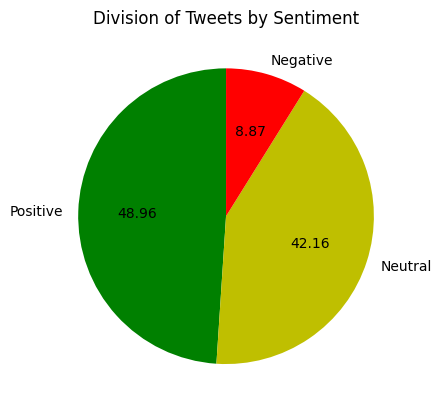

In [357]:
import matplotlib.pyplot as plt

label_count = updated_dataset['TextBlob Sentiment'].value_counts()
plt.pie(label_count.values, labels=label_count.index, autopct= '%1.2f', colors= ['g', 'y', 'r'], startangle= 90)
plt.title("Division of Tweets by Sentiment")
plt.show()

As mentioned previously in the data labelling section, there are almost equal number of postive and neutral tweets at 49% and 42% respectively with only ~9% negative tweets based on labelling with TextBlob.

<AxesSubplot: >

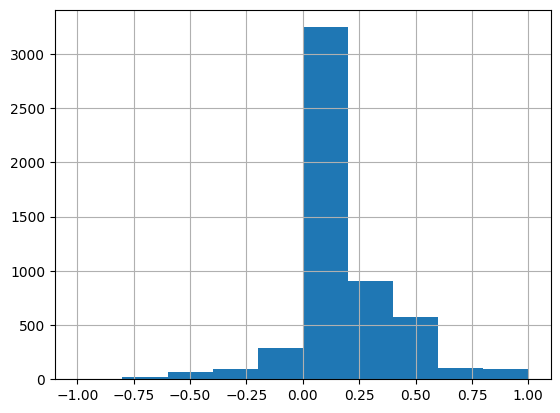

In [358]:
updated_dataset['TextBlob Polarity'].hist()

The histogram shows polarity of the tweets labelled using TextBlob. Majority of the tweets range between 0.00 to 0.55 polarity, showing us that most of the tweets are neutral or near positive. This is probably because most of the tweets scrapped lack indication of positive or negative sentiment.

### Analysing Each Sentiment

#### Postive Tweets

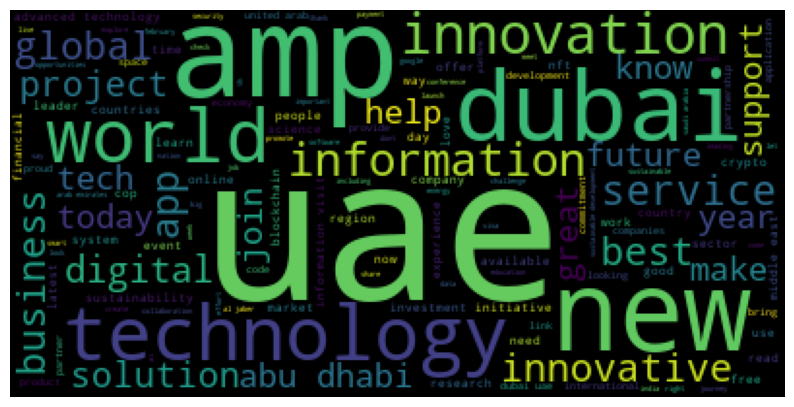

In [354]:
from wordcloud import WordCloud

positive = updated_dataset[updated_dataset['TextBlob Sentiment']=='Positive']
positives = ' '.join(tweet for tweet in positive['Cleaned Text'])
wordcloud_pos = WordCloud().generate(positives)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_pos)
plt.axis('off')
plt.show()

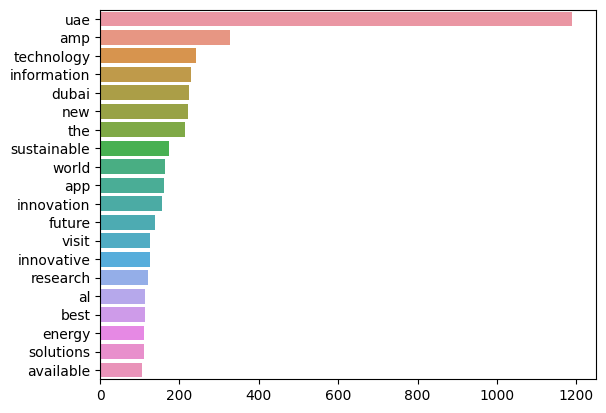

In [355]:
import seaborn as sns
from collections import  Counter

def plot_top_tokens(tweet):
    tweet = tweet.values.tolist()
    corpus=[word for i in tweet for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:20]:
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)

plot_top_tokens(positive['Tokenized Text'])

#### Neutral Tweets

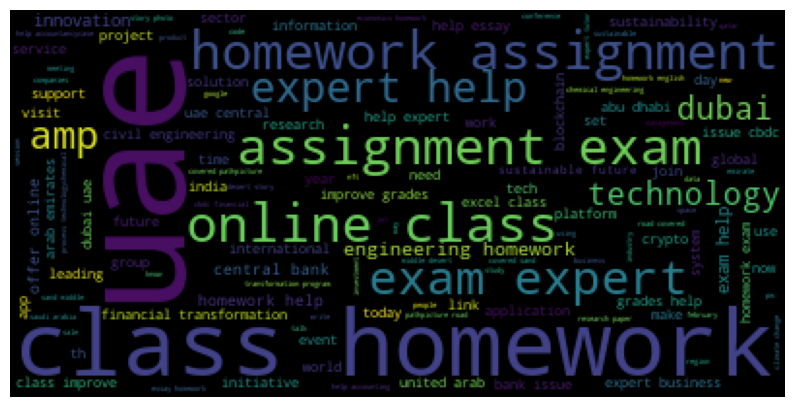

In [360]:
neutral = updated_dataset[updated_dataset['TextBlob Sentiment']=='Neutral']
neutrals = ' '.join(tweet for tweet in neutral['Cleaned Text'])
wordcloud_neu = WordCloud().generate(neutrals)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_neu)
plt.axis('off')
plt.show()

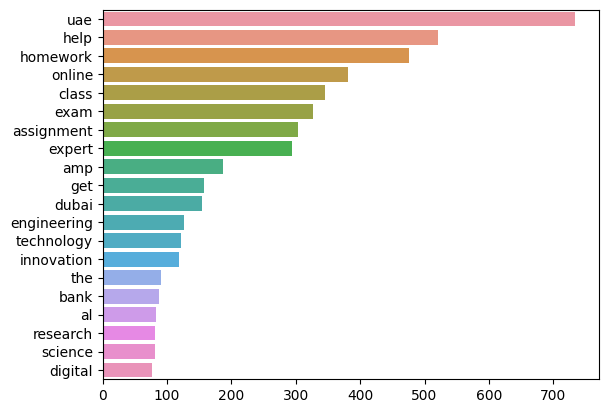

In [361]:
plot_top_tokens(neutral['Tokenized Text'])

#### Negative Tweets

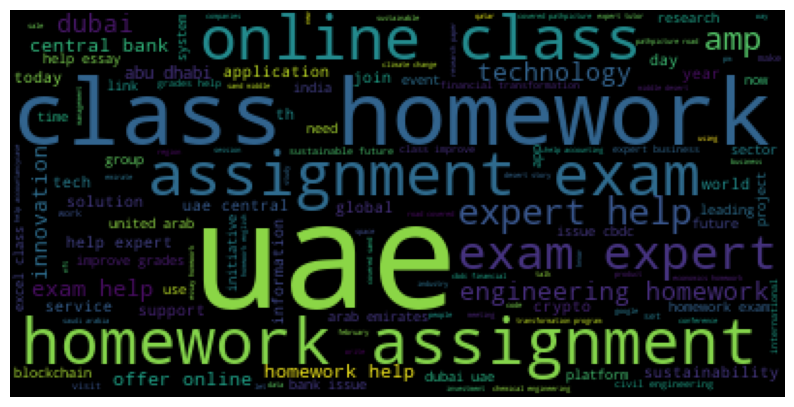

In [362]:
negative = updated_dataset[updated_dataset['TextBlob Sentiment']=='Negative']
negatives = ' '.join(tweet for tweet in negative['Cleaned Text'])
wordcloud_neg = WordCloud().generate(neutrals)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_neg)
plt.axis('off')
plt.show()

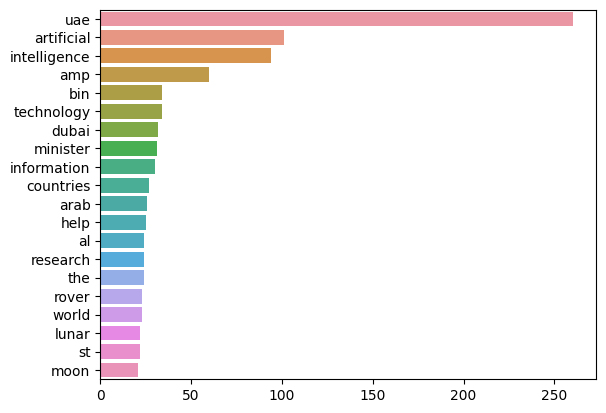

In [363]:
plot_top_tokens(negative['Tokenized Text'])